# TP de traitement du signal : Mesure de la vitesse du son


Ce notebook est dédié à la réalisation d'une maquette de traitement du signal dans le cadre du projet FIP. Le projet consiste en la conception et la réalisation de la maquette, ainsi qu'en la mise en œuvre du traitement du signal à partir des données collectées par les micros. Ce projet vous permettra d'acquérir des compétences en traitement du signal et de mieux comprendre son fonctionnement. Le code Python nécessaire pour le projet vous sera fourni et vous guidera à travers les différentes étapes du projet.

La maquette du projet permet de mesurer la vitesse du son, en effet en envoyant un signal sur le haut-parleur et en traitant l'acquisition des deux micros on pourra comparer la réception du signal et calculer la vitesse du son avec :

$v = \frac{d}{t}$

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


Temps PIC Gauche : 3.472108843537415
Temps PIC Droit : 3.470907029478458
Delta : 0.0012018140589571402
Vitesse : 416.037735848979 m/s


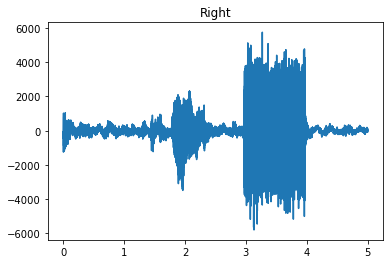

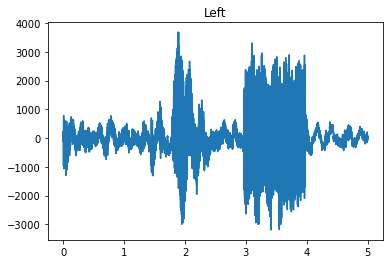

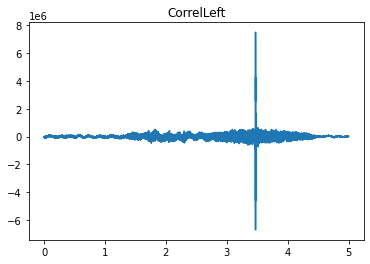

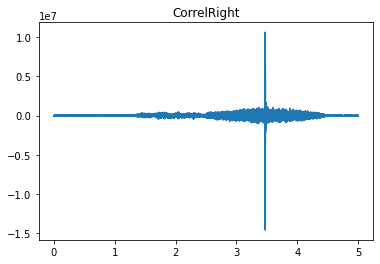

In [17]:
# Importer les bibliothèques nécessaires
# Gestion du son
import sounddevice as sd
import soundfile as sf
# Bibliothèques pour analyse traitement du signal
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
#Bibliothèques pour générer, acquérir les sons
import traitesignfip

traitesignfip.record_microphone("noise")

rate, data = scipy.io.wavfile.read('enregistrement.wav')

fs = 44100 # fréquence d'échantillonage
N=len(data) #nombre d'échantillions 
n = np.arange(0,N)/fs   #on divise par la fréquence d'échantillonage pour etre mieux dans l'échelle 


distance=0.50

data_right = data[:,1]
data_left = data[:,0]

#affichage du channel 1 
plt.figure()
plt.title("Right")
plt.plot(n,data_right)
plt.figure()
plt.title("Left")
plt.plot(n,data_left)

# fc = 1000 # fréquence de coupure du filtre passe-bas
# b, a = sp.signal.butter(4, fc / (fs / 2), 'low')
# data_left_filtered = sp.signal.filtfilt(b, a, data_left)
# data_right_filtered = sp.signal.filtfilt(b, a, data_right)


corrLeft=np.correlate(data_left,traitesignfip.samples, mode='same')
corrRight=np.correlate(data_right,traitesignfip.samples, mode='same')
# Calcul de la corrélation croisée entre les deux signaux

plt.figure()
plt.title("CorrelLeft")
plt.plot(n,corrLeft)
#signal X
plt.figure()
plt.title("CorrelRight")
plt.plot(n,corrRight)
#signal X



# Trouver l'indice du maximum de la corrélation
max_index_Left = np.argmax(corrLeft)/fs
max_index_Right = np.argmax(corrRight)/fs

delta_t = delta = np.abs(max_index_Left - max_index_Right)

print("Temps PIC Gauche : "+str(max_index_Left))
print("Temps PIC Droit : "+str(max_index_Right))

print("Delta : "+str(delta_t))
print("Vitesse : "+str(distance/delta_t)+" m/s")


In [30]:
import sounddevice as sd
import soundfile as sf
import threading
import time
#permet d'afficher un son
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

moyenne=[]

for i in range(4):
    samples_Bruit = np.random.normal(0, 1, int(44100))
    # Fonction pour générer un signal de bruit blanc
    def generate_white_noise(sample_rate):
        t = np.linspace(0,1,int(sample_rate),endpoint=False)
        zeros = np.zeros(3*sample_rate)
        return np.concatenate((zeros,samples_Bruit))

    # Fonction pour générer une sinusoïde de 440 Hz
    def generate_sine_wave(sample_rate):
        t = np.linspace(0,1,int(sample_rate),endpoint=False)
        zeros = np.zeros(3*sample_rate)
        frequency = 440  # Hz
        samples = (np.sin(2 * np.pi * np.arange(sample_rate ) * frequency / sample_rate)).astype(np.float32)
        return np.concatenate((zeros,samples))

    def generate_clap(sample_rate):
        t = np.linspace(0,1,int(sample_rate),endpoint=False)
        zeros = np.zeros(3*sample_rate)
        handclap=np.sin(2*np.pi*500*t)*np.exp(-5*t)
        return np.concatenate((zeros,handclap))

    # Fonction pour lire le signal sur les haut-parleurs
    def play_signal(signal, sample_rate):
        sd.play(signal, sample_rate)
        sd.wait()

    # Fonction pour enregistrer le son du microphone
    def record_microphone():
        duration = 5  # Durée de l'enregistrement en secondes
        sample_rate = 44100  # Fréquence d'échantillonnage en Hz
        channels = 2
        # Demander à l'utilisateur de choisir le type de signal à générer
        #signal_type = input("Entrez le type de signal à générer (1 : blanc | 2 : sinus | 3 : clap) : ")

        signal_type="1"

        if signal_type == "1":
            signal = generate_white_noise(sample_rate)
        elif signal_type == "2":
            signal = generate_sine_wave(sample_rate)
        elif signal_type == "3":
            signal = generate_clap(sample_rate)
        else:
            print("Type de signal non reconnu.")
            return

        # Démarrer un thread pour lire le signal sur les haut-parleurs
        play_thread = threading.Thread(target=play_signal, args=(signal, sample_rate))
        play_thread.start()

        # Enregistrer le son du microphone dans un fichier WAV
        recorded_audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels)
        sd.wait()  # Attendre la fin de l'enregistrement
        # Enregistrer les données audio dans un fichier WAV
        file_name = "enregistrement.wav"
        sf.write(file_name, recorded_audio, sample_rate, subtype='PCM_16')
        # Attendre la fin de la lecture du signal sur les haut-parleurs
        play_thread.join()

    # Démarrer un thread pour enregistrer le son du microphone et un autre thread pour jouer le signal en même temps
    record_thread = threading.Thread(target=record_microphone)
    record_thread.start()

    # Attendre la fin des deux threads
    record_thread.join()

    # Charger le fichier audio
    #rate, data = scipy.io.wavfile.read('enregistrement.wav')


    N=len(data) #nombre d'échantillions 
    n = np.arange(0,N)/44100   #on divise par la fréquence d'échantillonage pour etre mieux dans l'échelle 

    rate, data = scipy.io.wavfile.read('enregistrement.wav')

    data_right = data[:,1]
    data_left = data[:,0]
    distance=0.50

    #affichage du channel 1 
    # plt.figure()
    # plt.title("Right")
    # plt.plot(n,data_right)
    # plt.figure()
    # plt.title("Left")
    # plt.plot(n,data_left)
    #signal X
    t=np.arange(0,1,1/44100)
    f=440
    w=samples_Bruit
    #w=np.sin(2*np.pi*f*t+np.pi/3)
    #w=np.where(((t>=0.5) & (t<=1)),4000, 0)
    # plt.figure("Sinus")
    # plt.title("Sinus")
    # plt.plot(t,w)


    fs=44100

    # fc = 1000 # fréquence de coupure du filtre passe-bas
    # b, a = sp.signal.butter(4, fc / (fs / 2), 'low')
    # data_left_filtered = sp.signal.filtfilt(b, a, data_left)
    # data_right_filtered = sp.signal.filtfilt(b, a, data_right)


    corrLeft=np.correlate(data_left,w, mode='same')
    corrRight=np.correlate(data_right,w, mode='same')
    # Calcul de la corrélation croisée entre les deux signaux

    # plt.figure()
    # plt.title("CorrelLeft")
    # #plt.xlim(3.4,3.8)
    # plt.plot(n,corrLeft)
    # #signal X
    # plt.figure()
    # plt.title("CorrelRight")
    # #plt.xlim(3,3.01)
    # plt.plot(n,corrRight)
    #signal X

    dt = 1/44100
    fs = 44100

    # indicesL = np.where(np.abs(corrLeft) > 20000)[0]
    # indicesR = np.where(np.abs(corrRight) > 20000)[0]

    # Trouver l'indice du maximum de la corrélation
    max_index_Left = np.argmax(corrLeft)/fs
    max_index_Right = np.argmax(corrRight)/fs

    # max_index_Left = indicesL[0]/fs
    # max_index_Right = indicesR[0]/fs

    delta_t = delta = np.abs(max_index_Left - max_index_Right)

    print(str(i)+" itération : Temps PIC Gauche :"+str(max_index_Left))
    print(str(i)+" itération : Temps PIC Droit :"+str(max_index_Right))

    print(str(i)+" itération : Delta : "+str(delta_t))
    print(str(i)+" itération : Vitesse : "+str(distance/delta_t)+" m/s")

    moyenne.append(distance/delta_t)

value = 0

for i in moyenne:
    value += i 

value=value/len(moyenne)

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


0 itération : Temps PIC Gauche :3.4106122448979592
0 itération : Temps PIC Droit :3.4093877551020406
0 itération : Delta : 0.001224489795918604
0 itération : Vitesse : 408.3333333332544 m/s


ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun o

KeyboardInterrupt: 

ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8526:(snd_pcm_recover) underrun occurred


# Le code ci-dessous permet de filtrer le signal reçu


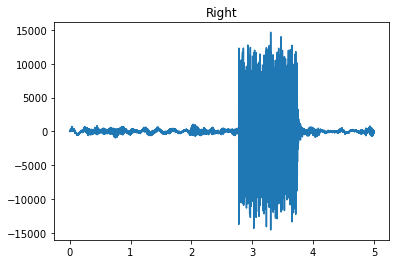

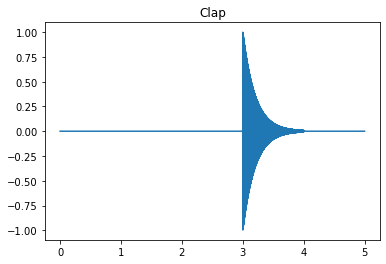

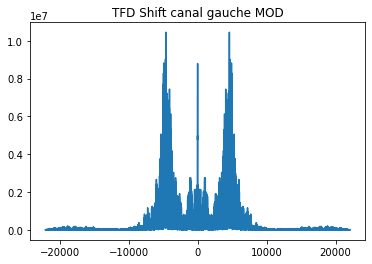

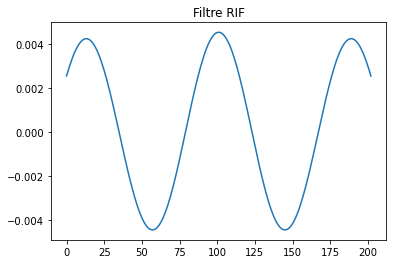

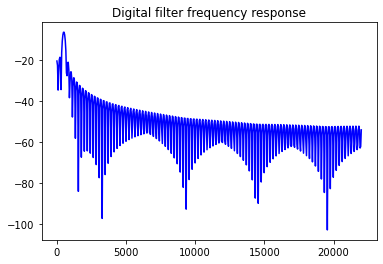

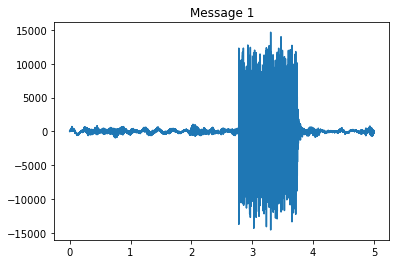

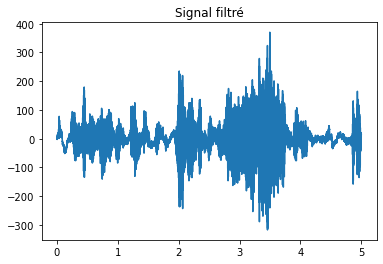

In [70]:
import numpy as np
import scipy.io.wavfile
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# SigNal M
rate, data = scipy.io.wavfile.read('enregistrement.wav')

N=len(data) #nombre d'échantillions 
n = np.arange(0,N)/44100 

data_right = data[:,1]
data_left = data[:,0]

plt.figure()
plt.title("Right")
plt.plot(n,data_left)
#signal X
t = np.linspace(0,1,int(44100),endpoint=False)
zeros = np.zeros(3*44100)
handclap=np.sin(2*np.pi*1000*t)*np.exp(-5*t)
handclap = np.concatenate((zeros,handclap))

for i in range(0,(len(n)-len(handclap))):
    handclap=np.append(handclap,0) 

plt.figure("Clap")
plt.title("Clap")
plt.plot(n,handclap)
h=np.correlate(data_left,handclap,"same")

Fe = 44100
Te = 1/Fe

tfd=np.fft.fft(data_left)
module = np.abs(tfd)
arg = np.angle(tfd)
N = len(data_left)
abscisse1 = np.arange(N) - np.floor(N/2)
freq1=abscisse1/(N*Te)

tfds=np.fft.fftshift(module)
tfdsarg=np.fft.fftshift(arg)

plt.figure("4")
plt.plot(freq1,tfds)
plt.title("TFD Shift canal gauche MOD")


f1=1950
f2=2050
fmax=44100/2
fe=44100

filtre = sp.signal.firwin(203,cutoff=[f1,f2],pass_zero="bandpass", window='boxcar',scale=False,fs=Fe)
#filtre = sp.signal.firwin(203,cutoff=[23,27],pass_zero="bandpass", window='hamming',scale=False,fs=Fe)
plt.figure()
plt.title("Filtre RIF")
plt.plot(filtre)

w, h = sp.signal.freqz(filtre,fs=Fe)
plt.figure()
plt.title('Digital filter frequency response')
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.show()



plt.figure()
plt.title('Message 1')
plt.plot(n,data_left)
plt.show()

filteredSignal = sp.signal.lfilter(filtre,1,data_left)
plt.figure()
plt.title('Signal filtré')
plt.plot(n,filteredSignal)
plt.show()



# Code pour la corrélation


Temps PIC Gauche :1.0438321995464852
Temps PIC Droit :3.0169160997732427
0.15204624596324687 m/s


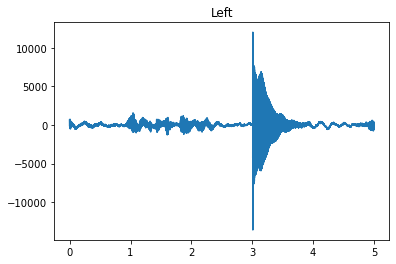

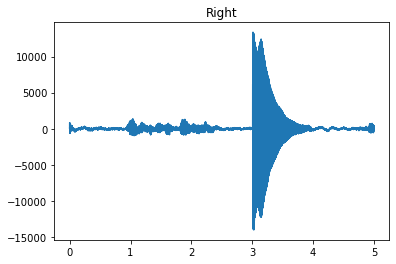

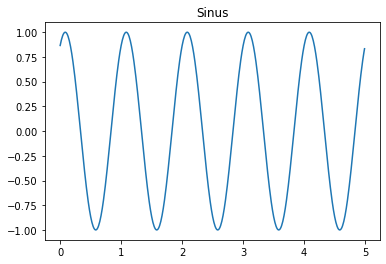

In [40]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt

# SigNal M
rate, data = scipy.io.wavfile.read('enregistrement.wav')

N=len(data) #nombre d'échantillions 
n = np.arange(0,N)/44100 

data_right = data[:,1]
data_left = data[:,0]



plt.figure()
plt.title("Left")
plt.plot(n,data_left)
#signal X
plt.figure()
plt.title("Right")
plt.plot(n,data_right)
#signal X
t=np.arange(0,5,0.01)
f=1
w=np.sin(2*np.pi*f*t+np.pi/3)
#w=np.where(((t>=0.5) & (t<=1)),4000, 0)
plt.figure("Sinus")
plt.title("Sinus")
plt.plot(t,w)

corrLeft=np.correlate(data_left,w, mode='same')
corrRight=np.correlate(data_right,w, mode='same')
# Calcul de la corrélation croisée entre les deux signaux

dt = 1/44100

# Trouver l'indice du maximum de la corrélation
max_index_Left = np.argmax(corrLeft)/44100
max_index_Right = np.argmax(corrRight)/44100

delta_t = np.abs(max_index_Left - max_index_Right)

print("Temps PIC Gauche :"+str(max_index_Left))
print("Temps PIC Droit :"+str(max_index_Right))

print(str(0.30/delta_t)+" m/s")
